# Self-consistent field methods

In the Introduction to density-functional theory we concluded that the non-linear eigenvalue
problem underlying DFT can be written as the fixed-point problem
$$
\rho = D(V(\rho)),
$$
where $V$ is the potential depending on the density $\rho$ and $D(V)$ is the potential-to-density
map, that is the construction of the DFT Hamiltonian $H(ρ) = -\frac12 Δ + V(ρ)$,
followed its diagonalisation to obtain its eigenpairs $(\varepsilon_{k i}, \psi_{ki})$
and from these a new density
$$
\rho(r) = \sum_i f\left(\varepsilon_{i}\right) \, \psi_{ki}(r) \, \psi_{ki}^\ast(r)
$$
with the Fermi level in the occupation function $f$ chosen such that the number of electrons is conserved.

In this chapter we will investigate the convergence properties of density-mixing SCF algorithms,
that is **damped, preconditioned fixed-point iterations**
$$
\rho_{n+1} = \rho_n + \alpha P^{-1} (D(V(\rho_n)) - \rho_n),
$$
where
*   $\alpha$ is a damping parameter, typically chosen between $0$ and $1$.
*   $P^{-1}$ is a preconditioner, which aims to improve convergence (details discussed further down).
* the iterations start from an initial guess $\rho_0$.
Our presentation follows [^HL2021], where more details can be found.

## SCF convergence analysis

We investigate the convergence properties of damped, preconditioned
iterations, in order to understand the choices for the preconditioning
stratege $P^{-1}$ as well as the damping parameter $\alpha$ to be made.

Near the fixed point $\rho_\ast = D(V(\rho_\ast))$ the error $e_n = \rho_n - \rho_\ast$ is small and we can expand to first order:
$$
\begin{align*}
D(V(\rho_\ast + e_n)) &\simeq D\left[V(\rho_\ast) + V'|_{\rho_\ast} e_n\right] \\
&\simeq D(V(\rho_\ast)) + D'|_{V(\rho_\ast)} V'|_{\rho_\ast} e_n\\
&= \rho_\ast + D'|_{V(\rho_\ast)} V'|_{\rho_\ast} e_n
\end{align*}
$$

The derivatives $D'$ and $V'$ are again important quantities and are given special symbols:
- Hartree-exchange-correlation **kernel** $K = V'$
- Independent-particle **susceptibility** $\chi_0 = D'$

where for simplicity it has been dropped that these quantities are evaluated at the fixed-point,
 i.e. at $\rho_\ast$ and $V(\rho_\ast)$, respectively.

The above expansion allows to relate the **error between SCF iterations** (near the fixed point):
$$
\begin{align*}
e_{n+1} = \rho_{n+1} - \rho_\ast
&= \rho_{n} - \rho_\ast + \alpha P^{-1} [D(V(\rho_\ast + e_n)) - \rho_n] \\
&\simeq \rho_{n} - \rho_\ast + \alpha P^{-1} [\rho_\ast + \chi_0 K e_n - \rho_n] \\
&= e_n - \alpha P^{-1} [1 - \chi_0 K] e_n.
\end{align*}
$$

Introducing the **dielectric matrix** adjoint
$$
\varepsilon^\dagger = [1 - \chi_0 K]
$$
leads to the final relationship
$$
e_{n+1} \simeq [1 - \alpha P^{-1} \varepsilon^\dagger] e_n = [1 - \alpha P^{-1} \varepsilon^\dagger]^n e_0
$$
with $e_0$ being the initial error. The SCF Jacobian is
$1 - \alpha P^{-1} \varepsilon^\dagger.$

In other words:
$$
\text{SCF converges} \qquad \Leftrightarrow \qquad \text{eigenvalues of $1 - \alpha P^{-1} \varepsilon^\dagger$ are between $-1$ and $1$}
$$

This implies that the **convergence** properties of an SCF
are related to $\varepsilon$, the dielectric operator,
which **depends on** the **dielectric properties** of the system under study.

In other words it depends on the conduction and screening properties, i.e. whether the material is an insulator, a semiconductor, a metal etc.

## Making an SCF converge

It turns out that for the largest chunk of cases the eigenvalues of
$\varepsilon^\dagger$ are positive. Moreover near a local minimiser
$\varepsilon^\dagger$ always has non-degative spectrum.

To make the SCF converge one can therefore:
- Choose $\alpha$ small enough. Even for $P = I$ this always works, but convergence can be painfully slow. (see e.g. the proof in [^HL2022])
- Find a good $P^{-1} \simeq (\varepsilon^\dagger)^{-1}$. Then the eigenvalues of $(P^{-1} \varepsilon^\dagger)$ are close to 1, $\alpha \simeq 1$ is a good choice and the SCF converges in few steps. Hooray!
- The optimal $\alpha$ and the optimal rate of convergence are directly related to the eigenvalues of $P^{-1} \varepsilon^\dagger$. Denoting by $\lambda_\text{min} > 0$ and $\lambda_\text{max}$ the smallest and largest eigenvalues of $P^{-1} \varepsilon^\dagger$, then the optimal damping is
  $$
   \alpha = \frac{2}{\lambda_\text{min} + \lambda_\text{max}}
  $$
  and the rate of convergence is (for large $\kappa$)
  $$
  r \simeq 1 - \frac{2}{\kappa}
  $$
  where the (spectral) condition number
  $$
  \kappa = \frac{\lambda_\text{max}}{\lambda_\text{min}}.
  $$
  Thus the smaller the condition number, the better the convergence.

**Note:** If the preconditioner is very bad, the eigenvalues of
$(P^{-1} \varepsilon^\dagger)$ might even be worse than $\varepsilon^\dagger$, such
that convergence is actually hampered by the preconditioner.

## Damped iterations
We start our practical investigation of typical SCF algorithms using the most simple case of $P=I$
and $α = 1$, i.e. the fixed-point iterations
$$
\rho_{n+1} = F(\rho_n),
$$
where thus the density is just sent through the SCF step function $F(\rho) = D(V(ρ))$
over and over again, starting from a hopefully good initial guess $\rho_0$ until
two successive densities differ by less than a desired threshold.

DFTK automatically provides a reasonable
guess density as well as function to evaluate $F(ρ)$,
such that we only need to take care of the iterations themselves.
In the language of DFTK this algorithm is written as:

In [1]:
using DFTK
using LinearAlgebra
function fixed_point_iteration(F, ρ₀, maxiter; tol)
    # F:        The SCF step function
    # ρ₀:       The initial guess density
    # maxiter:  The maximal number of iterations to be performed
    # tol:      The selected convergence tolerance

    ρ  = ρ₀
    Fρ = F(ρ)
    for n = 1:maxiter
        # If change less than tolerance, break iterations:
        if norm(Fρ - ρ) < tol
            break
        end
        ρ  = Fρ
        Fρ = F(ρ)
    end

    # Return some stuff DFTK needs ...
    (fixpoint=ρ, converged=norm(Fρ-ρ) < tol)
end;

To test this algorithm we use the following simple setting, which builds and discretises
a PBE model for an aluminium supercell.

In [2]:
using ASEconvert
using LazyArtifacts
import Main: @artifact_str # hide

function aluminium_setup(repeat=1; Ecut=13.0, kgrid=[2, 2, 2])
    ase_Al = ase.build.bulk("Al"; cubic=true) * pytuple((repeat, 1, 1))
    system = attach_psp(pyconvert(AbstractSystem, ase_Al);
                        Al=artifact"pd_nc_sr_pbe_standard_0.4.1_upf/Al.upf")
    model = model_PBE(system; temperature=1e-3, symmetries=false)
    PlaneWaveBasis(model; Ecut, kgrid)
end;

    CondaPkg Found dependencies: /home/runner/.julia/packages/ASEconvert/yMJC2/CondaPkg.toml
    CondaPkg Found dependencies: /home/runner/.julia/packages/PythonCall/S5MOg/CondaPkg.toml
    CondaPkg Dependencies already up to date
┌ Warning: using Pkg instead of using LazyArtifacts is deprecated
│   caller = eval at boot.jl:385 [inlined]
└ @ Core ./boot.jl:385


Now use this setup together with the `fixed_point_iteration` solver above
within an SCF. Note that the `damping` and `mixing` parameters are needed
here to disable some DFTK defaults we don't want to use just yet.

In [3]:
self_consistent_field(aluminium_setup(1); solver=fixed_point_iteration, damping=1.0,
                                          maxiter=30, mixing=SimpleMixing());

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -9.186749430080                   -1.09    7.5    10.0s
  2   -9.187708974164       -3.02       -2.38    1.0    977ms
  3   -9.187878891744       -3.77       -2.79    6.5    437ms
  4   -9.187810661453   +   -4.17       -2.32    2.2    225ms
  5   -9.187223180587   +   -3.23       -1.85    4.2    329ms
  6   -9.184721568542   +   -2.60       -1.49    4.0    378ms
  7   -9.178321858304   +   -2.19       -1.25    4.4    421ms
  8   -9.166109661015   +   -1.91       -1.08    5.0    465ms
  9   -9.144938362229   +   -1.67       -0.95    5.5    493ms
 10   -9.111577110300   +   -1.48       -0.84    8.2    595ms
 11   -9.047451259516   +   -1.19       -0.72    7.9    600ms
 12   -8.854319424362   +   -0.71       -0.55    7.4    587ms
 13   -8.503437850634   +   -0.45       -0.39   10.8    710ms
 14   -8.056104221543   +   -0.35       -0.26    9.0    706ms
 15   -7.

As can be observed this algorithm is not very good and in fact even fails to converge albeit we are only looking at a very simple system.

This is a known limitation of this algorithm, which is indeed why in practice one at least includes
the damping parameter $\alpha$ (with values usually between $0$ and $1$). One now iterates as follows:
$$
\rho_{n+1} = \rho_{n} + \alpha (F(\rho_n) - \rho_n)
$$

!!! tip "Exercise 1"
    Modify `fixed_point_iteration` such that it supports this *damped*
    fixed-point iteration. In other words implement damping *inside* your
    algorithm and not by changing the `damping` parameter of the
    `self_consistent_field` function driving the SCF.

    Using your algorithm try different values for $\alpha$ between $0$ and
    $1$ and estimate roughly the $\alpha$ which gives fastest convergence.
    For which $\alpha$ do you observe no convergence at all?

## Acceleration techniques
Before moving on to cases with $P \neq I$ we will briefly consider an orthogonal strategy
leading to faster SCF convergence, namely acceleration techniques.
Our discussion will focus on **Anderson acceleration**. In this approach one
exploits that the update $R(\rho) = F(\rho) - \rho$ is also the residual of
the fixed-point problem $F(\rho) = \rho$, i.e. how far away we are from the
fixed-point density. A good next density $\rho_{n+1}$ therefore should be
found by minimising an approximation for $R(\rho_{n+1})$. Assuming the SCF
was linear in the density (which it is not), a good idea is to find a linear
combination of residuals
$$
\min_{\beta_i} \left\| \sum_i \beta_i R(\rho_i) \right\|^2
$$
which has the smallest possible norm and to use these coefficients $\beta_i$ to extrapolate the next
density
$$
\rho_{n+1} =  \sum_i \beta_i (\rho_i + \alpha R(\rho_i))
$$
where you notice the "standard" damped fixed-point iteration in the summed terms.

This simple idea has been rediscovered a few times in different communities with only minor variations to the theme. This makes Anderson acceleration variably known as e.g. Anderson mixing, Pulay mixing or direct inversion of the iterative subspace (DIIS). The mathematical analysis of such methods is not yet exhaustive, see [M. Chupin, M. Dupuy, G. Legendre, É. Séré. *Math. Model. Num. Anal.* **55** 2785 (2021) DOI: 10.1051/m2an/2021069](http://dx.doi.org/10.1051/m2an/2021069) for a recent paper providing a good review of the state of the art.

A key result has been obtained by [Walker and Ni](https://doi.org/10.1137/10078356X), namely the equivalence of Anderson to the GMRES algorithm for linear problems. Based on this analysis Anderson-accelerated SCF procedures Anderson can be expected to inherit the GMRES convergence properties near a fixed point, resulting in a rate of convergence of
$$
r \simeq 1 - \frac{2}{\sqrt{\kappa}}.
$$
In terms of an algorithm Anderson iteration is

In [4]:
function anderson_iteration(F, ρ₀, maxiter; tol)
    # F:        The SCF step function
    # ρ₀:       The initial guess density
    # maxiter:  The maximal number of iterations to be performed
    # tol:      The selected convergence tolerance

    converged = false
    ρ  = ρ₀
    ρs = []
    Rs = []
    for n = 1:maxiter
        Fρ = F(ρ)
        Rρ = Fρ - ρ
        converged = norm(Rρ) < tol
        converged && break

        ρnext = vec(ρ) .+ vec(Rρ)
        if !isempty(Rs)
            M = hcat(Rs...) .- vec(Rρ)
            βs = -(M \ vec(Rρ))

            for (iβ, β) in enumerate(βs)
                ρnext .+= β .* (ρs[iβ] .- vec(ρ) .+ Rs[iβ] .- vec(Rρ))
            end
        end

        push!(ρs, vec(ρ))
        push!(Rs, vec(Rρ))
        ρ = reshape(ρnext, size(ρ₀)...)
    end

    # Return some stuff DFTK needs ...
    (fixpoint=ρ, converged=converged)
end;

To work with this algorithm we will use DFTK's intrinsic mechanism to choose a damping. The syntax for this is

```julia
repeat = 1
self_consistent_field(aluminium_setup(repeat);
                      solver=anderson_iteration,
                      damping=0.8, maxiter=40,
                      mixing=SimpleMixing());
```
to choose a damping of $\alpha = 0.8$ and run for at most `maxiter` iterations.

!!! tip "Exercise 2"
    Based on this Anderson implementation verify (by making a few experiments) that the algorithm converges for `repeat=1` for any $0 < \alpha \leq 2$. You may now use the `damping` parameter for changing the value $\alpha$ used by the SCF. State the number of iterations and runtimes you observe.

!!! tip "Exercise 3"
    Pick $\alpha = 0.8$ and make the problem harder by increasing `repeat` (e.g. `2`, `4`, `6`, `8`). Can you make Anderson fail to converge? What do you notice in terms of the number of iterations and runtimes?

DFTK actually employs a numerically more stable Anderson acceleration implementation by default
if the `solver` keyword argument is not provided to `self_consistent_field`.
For practical calculations this should be used instead of a custom version.

## Metals and charge sloshing

Anderson allows us to push the boundary for SCF methods, but for larger or
more challenging systems it is not fully sufficient. The next ingredient for
a stable SCF procedure is based on the insight that the convergence
properties of an SCF provably depend on the dielectric properties of
materials, which is simulated. Amongst others this is to say that insulators
(like glass), semiconductors (like silicon) or metals (like aluminium) have
rather differing SCF behaviours. As a result the ideal SCF procedure should
be slightly different for each material.

To investigate this further theoretically
Recall the definition $\varepsilon^\dagger = 1 - \chi_0 K$. The Hartree-exchange-correlation kernel can be further decomposed into
$$
K = v_c + K_\text{xc},
$$
where $v_c$ is the classical Coulomb kernel we introduced previously and $K_\text{xc} = d^2 E_\text{xc}(\rho)$ is the Hessian of the exchange-correlation energy functional.

For well-behaved systems the smallest eigenvalue of $\varepsilon^\dagger$ is around $1$ while the largest eigenvalue is of order $10$ (or less). Due to a number of instabilities in the modelled systems either the smallest eigenvalue can decrease or the largest eigenvalue can increase, thus giving a larker condition number $\kappa$ and worse convergence. For a detailed discussion, see Section 2 of [^HL2021].

In this discussion we will restrict ourselves to a single source of instabilities, namely the one due to the long range divergence of the Coulomb kernel $v_c$. Indeed, if $\hat{\rho}(q)$ are the Fourier coefficients of the density, then
$$
\widehat{(v_c \rho)}(q) = \frac{4\pi \hat{\rho}(q)}{|q|^2},
$$
which diverges for small $q$ (long wavelength). If this divergence is not compensated by $\chi_0$, this can manifest in large eigenvalues of $\varepsilon^\dagger$. (Note that $\chi_0$ is a non-positive operator and $K_\text{xc}$ has usually little influence on the large eigenmodes of $\varepsilon^\dagger$.)

For **metals** it turns out that $\chi_0$ is approximately constant in the long-wavelength limit ($q \to 0$), namely the negative density of states $D$ (per volume) at the Fermi level:
$$
\lim_{q\to0} \chi_0(q) \simeq -D.
$$
Therefore as one treats larger and larger metallic systems, smaller wavelengths $q$ become accessible in the discretised problem, which causes $\lambda_\text{max}$ to increase --- in theory quadratically with system size. This phaenomenon, known as **charge sloshing** makes it difficult to treat large metallic systems without proper preconditioning.

In contrast for **insulators** and **semiconductors** a good approximation of $\chi_0(q)$ for small $q$ is $-q^T \sigma_0 q$, where $\sigma_0$ is a material-dependent symmetric positive matrix. Therefore the $1/q^2$ instability is compensated and treating larger cells is less difficult.

## Preconditioning strategies (mixing methods)

The natural approach to deal with the large-wavelength instabilities mentioned in the previous section, is to develop an approximate dielectric model $P \simeq \varepsilon^\dagger$, which can be used to compensate the large eigenvalues of $\varepsilon^\dagger$, i.e. such that $P^{-1} \varepsilon^\dagger$ keeps a manageable condition number $\kappa$ and thus a fast SCF convergence.

To simplify the discussion we will employ the so-called **random-phase approximation**, where we set $K \simeq v_c$, i.e. $\varepsilon^\dagger = 1 - \chi_0 v_c$. This approximatiion is justified for analysing the large-wavelength limit, where $v_c$ dominates over $K$.

### Bulk dielectric models

The most practical strategy is to directly propose analytical expressions directly for $P^{-1}$. The rationale is that these are fast to evaluate and their cost can thus be neglected in an SCF. For **bulk materials** this is feasible building on the justified approximation to ignore lattice-scale details. Mathematically one may (a) take the $q\to0$ limit and (b) model $\chi_0$ as a translation-independent operator. Such operators (compare to the Kinetic energy) are diagonal in Fourier space and are fully characterised by their Fourier multiplier $\chi_0(q)$. Since $v_c$ is also translation-independent, this implies that the resulting model for the dielectric operator $P \simeq \varepsilon^\dagger$ is translation-independent and its inverse can be directly computed as $P^{-1}(q) = \frac{1}{P(q)}$ enabling an analytical computation of the inverse of the preconditioner from a dielectric model.

For **metals** the observation $\lim_{q\to0} \chi_0(q) \simeq -D$ directly leads to the **Kerker preconditioner**
$$
P_\text{Kerker}^{-1}(q) = \left( 1 - \frac{4\pi -D}{|q|^2} \right)^{-1} = \frac{|q|^2}{|q|^2 + 4\pi D}.
$$
The Kerker preconditioner is available in DFTK as `KerkerMixing` and `KerkerDosMixing` (which automatically determines the density of states from the current orbitals and occupations).

For **semiconductors** and **insulators** one can identify $\varepsilon_r = \varepsilon(q = 0) = 1 + 4\pi \sigma_0$ (in the case of isotropic $\sigma_0$), where $\varepsilon_r$ can be interpreted as the macroscopic electronic dielectric constant. From this limit for long wavelengths a number of empirical models for $\chi_0(q)$ and $\varepsilon^\dagger(q)$ have been proposed in the literature. A simple, two-parameter model is
$$
P_\text{Dielectric}^{-1}(q) = \frac{\varepsilon_r + (\varepsilon_r-1) \frac{|q|^2}{k_\text{TF}^2}}{1 + (\varepsilon_r-1) \frac{|q|^2}{k_\text{TF}^2}},
$$
where $k_\text{TF}$ is another parameter.
This model is available in DFTK as `DielectricMixing`.

Below is a sketch of the three models using the appropriate setups for aluminium (a metal), gallium arsenide (a semiconductor, $\varepsilon_r = 14.9$) and silica (an insulator, $\varepsilon_r = 1.5$) for comparison:

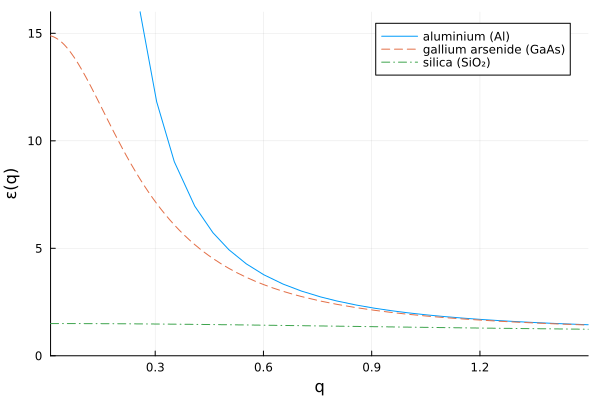

In [5]:
using Plots

χ0_metal(q, kTF=1) = -kTF^2 / 4π
χ0_dielectric(q, εr, C₀=1-εr, kTF=1) = C₀*q^2 / (4π * (1 - C₀*q^2/kTF^2))
χ0_GaAs(q) = χ0_dielectric(q, 14.9)
χ0_SiO2(q) = χ0_dielectric(q, 1.5)
ε(χ0, q) = (1 - 4π/q^2 * χ0(q))

p = plot(xlims=(1e-2, 1.5), ylims=(0, 16), xlabel="q", ylabel="ε(q)", lw=4)
plot!(p, x -> ε(χ0_metal, x), label="aluminium (Al)")
plot!(p, x -> ε(χ0_GaAs, x),  label="gallium arsenide (GaAs)", ls=:dash)
plot!(p, x -> ε(χ0_SiO2, x),  label="silica (SiO₂)", ls=:dashdot)

As expected from this discussion, for insulators $P = I$ (no preconditioner) is sufficient, while for the two other cases, an appropriate preconditioner is needed to ensure good convergence properties for large systems.

Here we show the results for three large bulk systems (40 unit cells) of the three materials:


|   Aluminium (a metal)                                     |   Gallium arsenide (a semiconductor)   |   Silica (an insulator)   |
| :-------------------------------------------------------: | :------------------------------------: | :-------: |
| <img src="Al_repeat_40.png" width=300 />   | <img src="GaAs_repeat_40.png" width=300 /> | <img src="SiO2_repeat_39.png" width=300 /> |

### Susceptibility models and LDOS preconditioner

While the bulk preconditioning models mentioned above are a good step forward, they have two key disadvantages:
1. Since the preconditioner models (especially between metals and insulators) are rather distinct, the preconditioner needs to match the modelled material to ensure fast convergence for large systems. In other words one needs to know **a priori** what material one is modelling.
2. Being by nature bulk models, they miss important applications featuring inhomogeneous systems, such as catalytic surfaces, metal clusters etc.

In order to overcome the second point it is important to realise that we need to give up on the translational independence of $\chi_0$, i.e. we no longer are able to compute $P^{-1}(q)$ by $1/P(q)$. Our strategy will therefore be to construct more sophisticated approximations to $\chi_0$, denoted by $\widetilde{\chi_0}$. The preconditioned density $x_n = P^{-1} \rho_n = (1 - \widetilde{\chi_0} v_c)^{-1}$ is then obtained by solving
$$
(1 - \widetilde{\chi_0} v_c) x_n = \rho_n
$$
iteratively for $x_n$ using GMRES.

Note that $\chi_0(r, r')$ has unit-cell internal fluctuations, but is overall diagonal dominant

<img src="https://docs.dftk.org/stable/guide/chi0.png" width=400 />

Starting from the Adler-Wiser formula
$$
\begin{align*}
   \chi_0(\vec{r}, \vec{r}')
     &= \sum_{n, m} \frac{f_\text{FD}(\varepsilon_n) - f_\text{FD}(\varepsilon_m)}{\varepsilon_n - \varepsilon_m}                \psi_n(\vec{r}) \psi_m^\ast(\vec{r})
        \psi_m(\vec{r}') \psi_n^\ast(\vec{r}')%\\
\end{align*}
$$
we want to capture the large-scale variations from $\rho_n$ to $\rho_{n+1}$ to counteract the charge-sloshing. Set $V = v_c \rho_n$ and assume $\vec{r} \mapsto \chi_0(\vec{r}, \vec{r}')$ to be more localised around $\vec{r}'$ than $V(\vec{r}')$. Then apply *row-sum mass lumping* to homogenise the operator:
$$
\begin{align*}
  \int \chi_0(\vec{r}, \vec{r}') V(\vec{r}') d\vec{r}'
    &\simeq V(\vec{r})\int \chi_0(\vec{r}, \vec{r}') d\vec{r}'\\
    &= V(\vec{r}) \sum_{n, m} \frac{f(\varepsilon_n) - f(\varepsilon_m)}
                  {\varepsilon_n - \varepsilon_m}
                  \psi_n(\vec{r}) \psi_m^\ast(\vec{r}) \delta_{mn}\\
    &= V(\vec{r}) \sum_n f'(\varepsilon_n) |\psi_n(\vec{r})|^2\\
    &= V(\vec{r}) \cdot \Big(- \text{LDOS}(\vec{r}) \Big)
\end{align*}
$$
Overall we thus approximate
$$
\chi_0(r, r') \simeq - \text{LDOS}(r) \, \delta(r, r')
$$

Note that this approach yields a generic framework, where further terms (capturing other physics of $\chi_0$) could be easily employed on top of the $-\text{LDOS}$ term.

To conclude this chapter we show some results for mixed systems featuring various combinations of metals, insulators and semiconductors. In the table both the number of iterations as well as the condition number is shown. Cases where the condition number does not more than double as the system size is doubled are coloured.

<img src="ldos_table.png" width="700px" />

For the two metal-insulator systems, exemplary convergence curves are shown below:

|   Aluminium + Vacuum     |   Aluminium + Silica    |
| :---------------------------------: | :----------------: |
| <img src="alvac.png" width=400 /> | <img src="alsio2.png" width=400 /> |
| <img src="AlVac_repeat_20.png" width=400 />   | <img src="AlSiO2H_repeat_20.png" width=400 /> |

The LDOS preconditioning strategy is available in DFTK as `LdosMixing`. Since it is parameter-free and applicable to a wide range of systems (any mixture of insulator and metals), it is used by default in DFTK.

## Preconditioned SCF methods in practice

We return to our aluminium setting produced by `aluminium_setup`.
In this case we are dealing with a prototypical
metal, such that `KerkerMixing` is indeed appropriate. We will thus employ it as
the preconditioner $P$ in the setting
$$
rho_{n+1} = \rho_n + \alpha P^{-1} (D(V(\rho_n)) - \rho_n),
$$
In DFTK this is done by running an SCF as follows:
```julia
self_consistent_field(basis; damping=0.8, mixing=KerkerMixing());
```

If you wonder about the use of Anderson acceleration in this context:
It can simply be re-introduced by replacing the previous definition of $R$ by
$R(\rho) = P^{-1} (F(\rho_n) - \rho_n)$. Again DFTK does exactly this by default
if no other `solver` is passed to `self_consistent_field`.

!!! tip "Exercise 4"
    Try the Anderson-accelerated and `KerkerMixing`-preconditioned setup for
    different values of `repeat` in `aluminium_setup`
    and check the number of iterations needed. Other mixings DFTK has to offer are `DielectricMixing` (best for semiconductors), `SimpleMixing` (which is $P = I$, i.e. no preconditioner at all, best for insulators) or `LdosMixing` (self-adapting, suitable for both metals *or* insulators *or* inhomogeneous mixtures). Note that `LdosMixing` is the default in DFTK (i.e. used if the `mixing` parameter is *not* supplied to `self_consistent_field`. Try these mixings (`SimpleMixing`, `DielectricMixing`, `LdosMixing` and `KerkerMixing`) and summarise your findings.

You should notice that choosing a preconditioner matching the material under study aids a fast SCF convergence, but that sometimes being off does not seem to do much harm for our case. For larger values of `repeat` (beyond what you can probably effort on your laptop) this is no longer true and one needs to be very careful in selecting the right preconditioner. See for example the investigation in [^HL2021].

[^HL2021]: M. Herbst, A. Levitt. *J. Phys.: Condens. Matter* **33** 085503 (2021) DOI: [10.1088/1361-648x/abcbdb](http://dx.doi.org/10.1088/1361-648x/abcbdb)
[^HL2022]: M. Herbst, A. Levitt *J. Comp. Phys.* **459** 111127 (2022). DOI [10.1016/j.jcp.2022.111127](http://dx.doi.org/10.1016/j.jcp.2022.111127)